# <span style="color:#1B4F72">Gaze-based Autism Detection Using Videos</span>

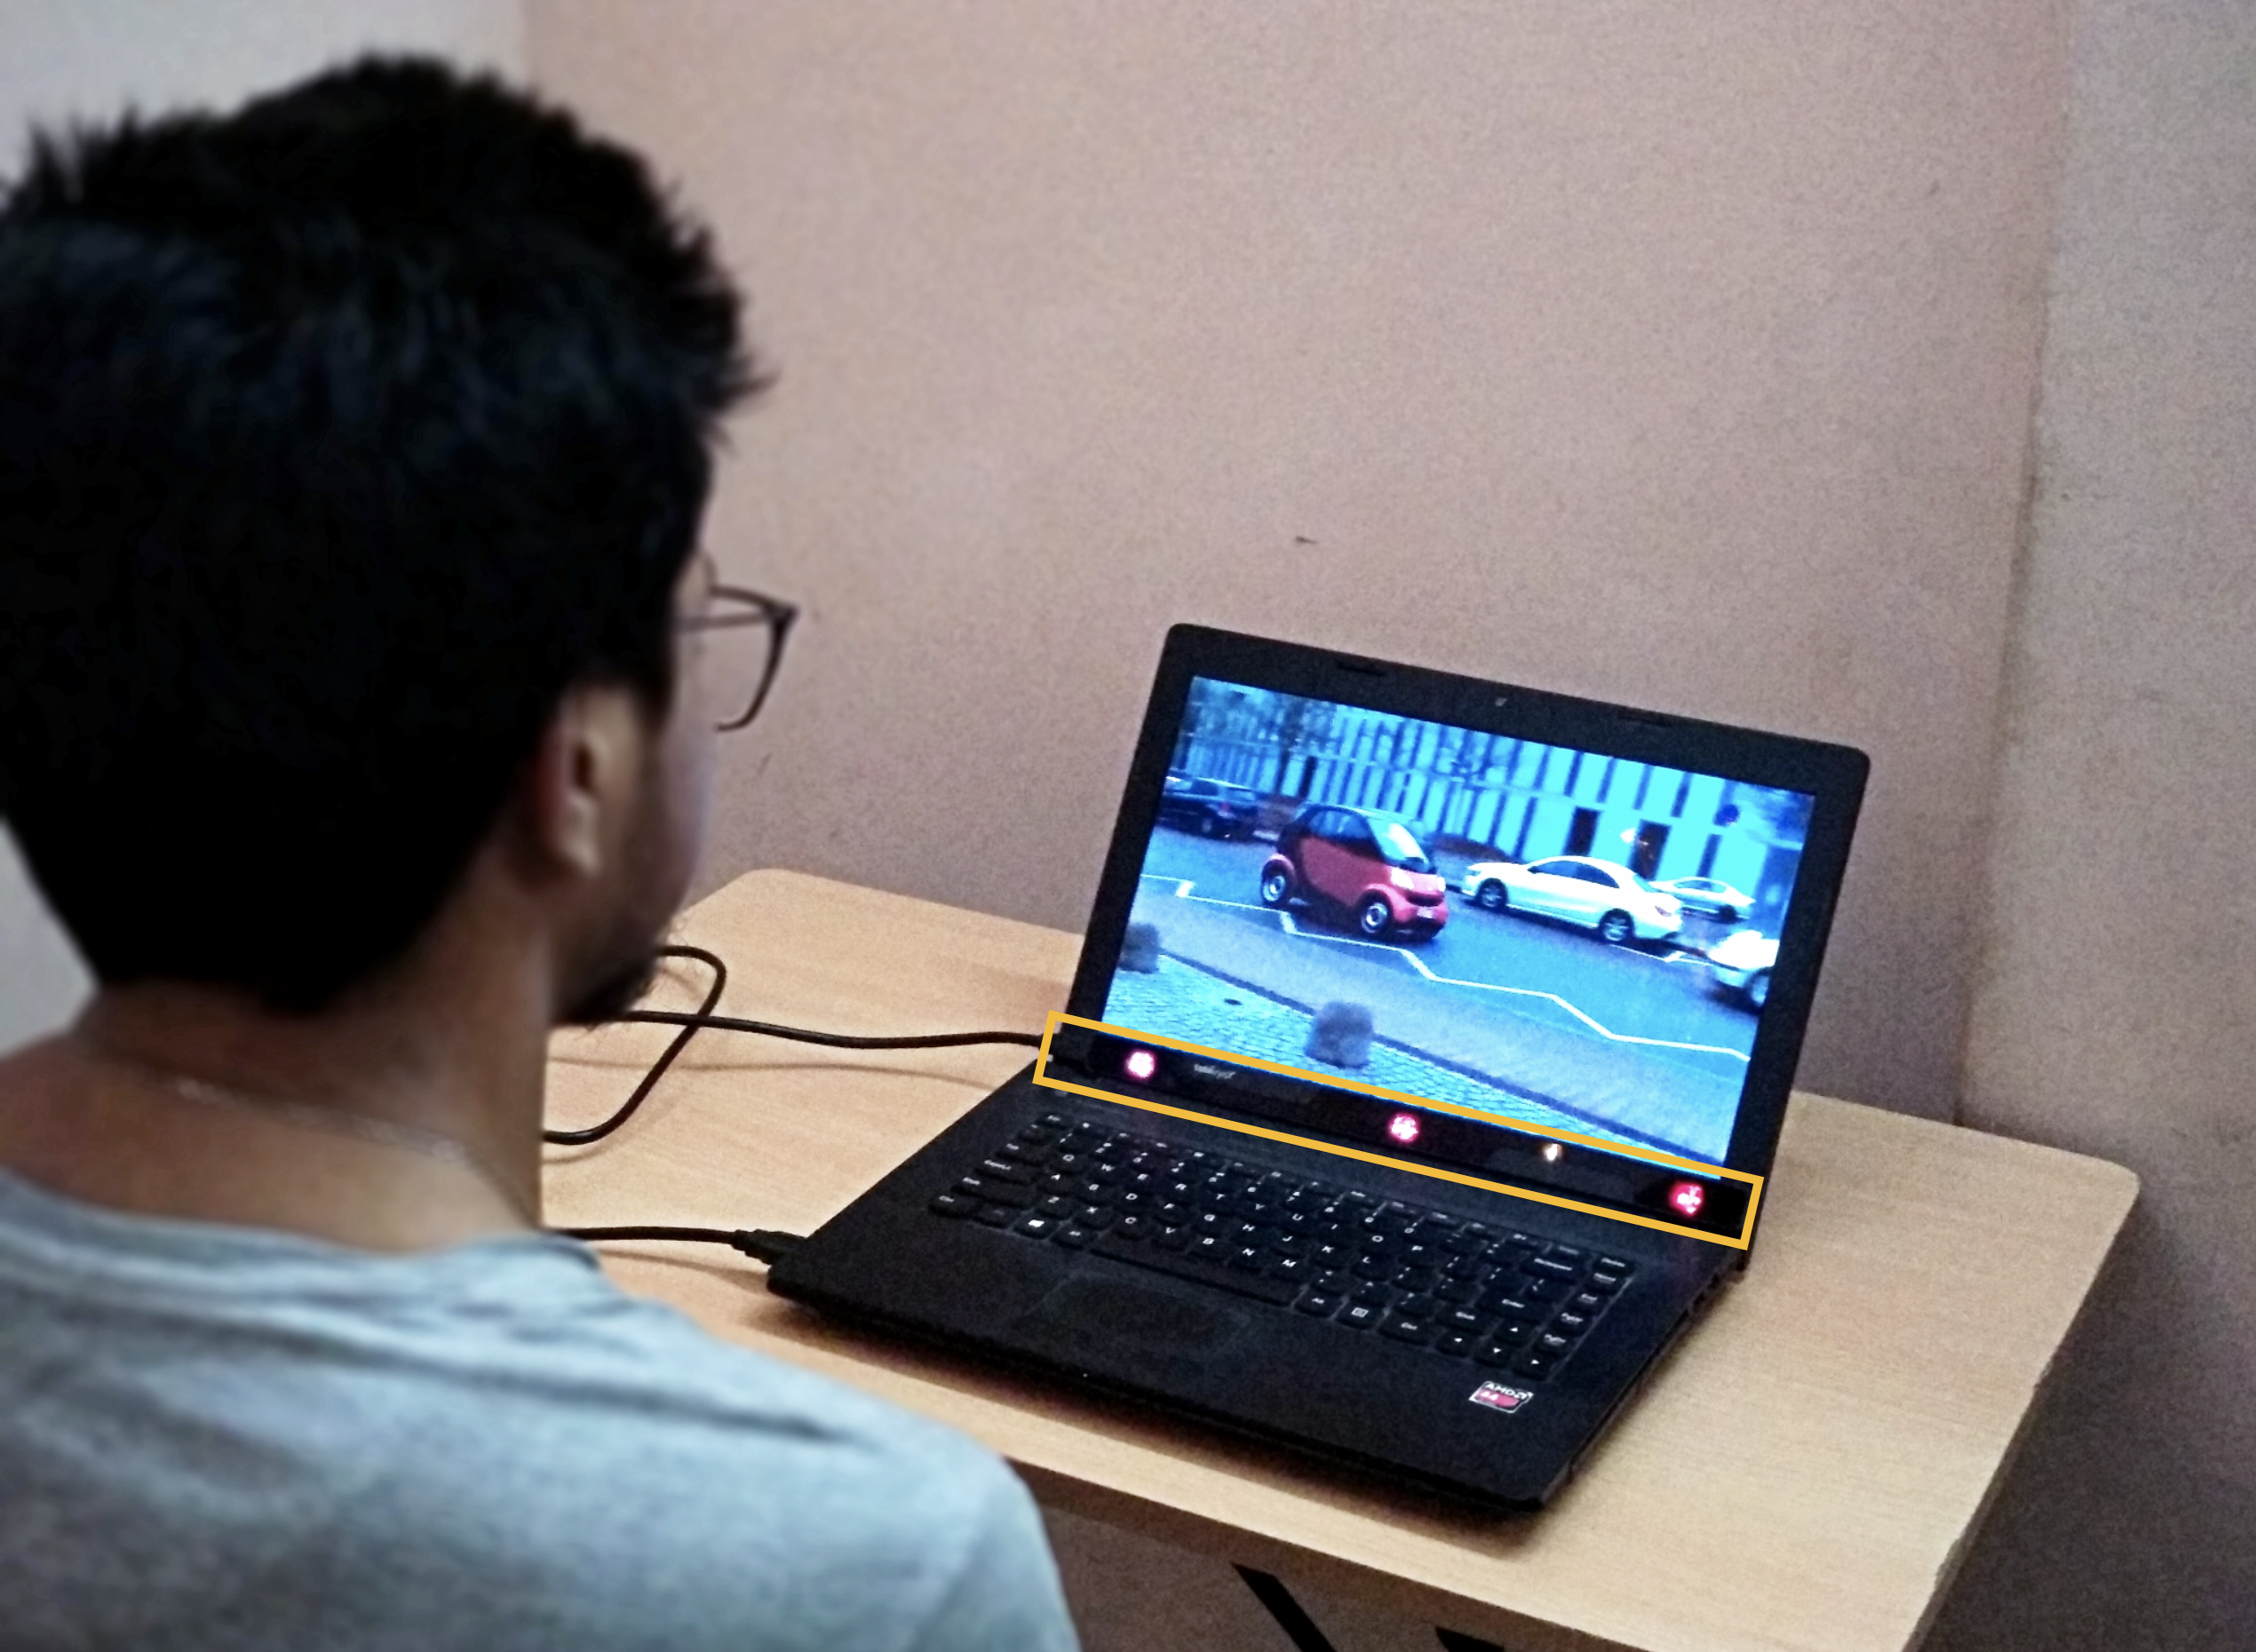

## <span style="color:#873600">Importing libraries</span>

In [61]:
# run this code

import numpy as np
import random
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

#Note: these includes are just a guide. You are allowed to use anything 
#from the packages outlined in "Environment.pdf" under Assignment 1 on Canvas.

## <span style="color:#873600">Task 1: Data loading</span>

In the **next** cell create methods to load the sensor data from numpy files.

In [62]:
#run this code

root = 'gaze-detection_npy-data/' #You should change this to where you keep the data

def load_raw_data_autistic():
    test_X1= np.load(f'{root}vid_1_gaze_test_X.npy')
    test_Y1= np.load(f'{root}vid_1_gaze_test_Y.npy')

    test_X2= np.load(f'{root}vid_2_gaze_test_X.npy')
    test_Y2= np.load(f'{root}vid_2_gaze_test_Y.npy')

    #You can load more videos if you would like here (optional extra credit)...

    test_X3= np.load(f'{root}vid_5_gaze_test_X.npy')
    test_Y3= np.load(f'{root}vid_5_gaze_test_Y.npy')

    test_X4= np.load(f'{root}vid_7_gaze_test_X.npy')
    test_Y4= np.load(f'{root}vid_7_gaze_test_Y.npy')

    return (test_X1, test_X2, test_X3, test_X4), (test_Y1, test_Y2, test_Y3, test_Y4) #make sure to add them to your tuples too

def load_raw_data_non_autistic():
    gaze_X1= np.load(f'{root}vid_1_gaze_GT_X.npy')
    gaze_Y1= np.load(f'{root}vid_1_gaze_GT_Y.npy')

    gaze_X2= np.load(f'{root}vid_2_gaze_GT_X.npy')
    gaze_Y2= np.load(f'{root}vid_2_gaze_GT_Y.npy')

    #You can load more videos if you would like here (optional extra credit)...

    gaze_X3= np.load(f'{root}vid_5_gaze_GT_X.npy')
    gaze_Y3= np.load(f'{root}vid_5_gaze_GT_Y.npy')

    gaze_X4= np.load(f'{root}vid_7_gaze_GT_X.npy')
    gaze_Y4= np.load(f'{root}vid_7_gaze_GT_Y.npy')

    return (gaze_X1, gaze_X2, gaze_X3, gaze_X4), (gaze_Y1, gaze_Y2, gaze_Y3, gaze_Y4) #make sure to add them to your tuples too

def load_data_autistic():
    tuple_X, tuple_Y = load_raw_data_autistic()
    test_points_X = np.concatenate(tuple_X, axis=1)
    test_points_Y = np.concatenate(tuple_Y, axis=1)

    return test_points_X, test_points_Y

def load_data_non_autistic():
    tuple_X, tuple_Y = load_raw_data_non_autistic()
    gaze_GT_X=np.concatenate(tuple_X, axis=1)
    gaze_GT_Y=np.concatenate(tuple_Y, axis=1)

    return gaze_GT_X, gaze_GT_Y

In [63]:
#printing out our data...

autistic_X, autistic_Y = load_data_autistic()
control_X, control_Y = load_data_non_autistic()

print(autistic_X.shape, autistic_Y.shape)
print(control_X.shape, control_Y.shape)

(35, 2332) (35, 2332)
(25, 2332) (25, 2332)


Did you use additional files? (Yes or No)
<Using additional files will give you 5 extra credit>

R/ Yes

## <span style="color:#873600">Task 2: choose wisely your features.</span>
Add features that allow you to reliably identify users with autism symptoms.

In [64]:
# Featurize each subject's gaze trajectory in the file
# This method is run once for each video file for each condition

def featurize_input(X, Y):
    out = []
    # Where i is each subject in the file
    for i in range(len(X)):
        X_cord = X[i]
        Y_cord = Y[i] #NOT USED (but you can add Y features if you like)
        fv = []
        
        # ADD CODE HERE #
        #add your features to fv (each feature here should be a single number)
        #you should replace the appends below with better features (mean, min, max, etc.)
        fv.append(np.std(X_cord))
        fv.append(np.std(Y_cord))
        fv.append(np.mean(X_cord))
        fv.append(np.mean(Y_cord))
        fv.append(np.max(X_cord) - np.min(X_cord))
        fv.append(np.max(Y_cord) - np.min(Y_cord))

        # fv.append(random.random())# use to test noise.. gives poor accuracy
        # fv.append(X_cord[0]) #initial X position
        # fv.append(X_cord[-1]) #final X position

        out.append(fv)

    out = np.array(out)

    return out

In [65]:
# run this code

def load_data_autistic_fv():
    tuple_X, tuple_Y = load_raw_data_autistic()

    fv_list = []
    for X, Y in list(zip(tuple_X, tuple_Y)):
      fv_list.append(featurize_input(X, Y))

    fv = np.concatenate(tuple(fv_list), axis=1)

    return fv

def load_data_non_autistic_fv():
    tuple_X, tuple_Y = load_raw_data_non_autistic()

    fv_list = []
    for X, Y in list(zip(tuple_X, tuple_Y)):
      fv_list.append(featurize_input(X, Y))

    fv = np.concatenate(tuple(fv_list), axis=1)

    return fv

In [66]:
# run this code

# get feature engineered vectors
autistic_fv = load_data_autistic_fv()
control_fv = load_data_non_autistic_fv()

print(autistic_fv.shape, control_fv.shape)

(35, 24) (25, 24)


**<span style="color:#873600">Question</span>**: Is there any problem since the number of autistic and control participants is not the same? Answer in the next cell. Justify your answer.

Answer: There doesn't necessarily have to be a problem with that, but it's less than ideal. A balanced dataset is better for training the machine because ideally it will learn the differences between the classes more accurately. However in this case, since we're using an SVM and the data difference isn't that much, it shouldn't have too much of an impact.

## <span style="color:#873600">Task 3: balance the datasets.</span>
Balance your datasets. Explain your method and **comment** about your decision.

In [67]:
# ADD CODE HERE
# NOTE: DO NOT RUN THIS CODE BLOCK ALONE MULTIPLE TIMES
if autistic_fv.shape[0] != control_fv.shape[0]:
    for i in range(autistic_fv.shape[0] - control_fv.shape[0]):
        extra = control_fv[i].copy()
        changes = np.random.normal(size=len(extra))
        extra += changes
        control_fv = np.vstack([control_fv, extra])

# sanity check
print(autistic_fv.shape)
print(control_fv.shape)

(35, 24)
(35, 24)


Explanation: This is a fairly simple expansion of the minority class that doesn't require any outside algorithms like SMOTE. Since all of the features are numerical and usually fairly large or at least large enough to the point where plus or minus 0.5 won't matter too much, I simply take some of the minority class, add a standard normal value to each value in that array, then append the new array to the end of the 2d feature array. This is essentially copying certain examples over, but with a very small amount of variance in there to add some randomness.

## <span style="color:#873600">Task 4: dealing with ground truth.</span>
Add the ground truth (labels) to the data.

In [68]:
# run this code

#Assigning groundtruth conditions to each participant. 
labels_aut = [1.0] * len(autistic_fv) 
labels_control = [0.0] * len(control_fv)

#Make data and labels vectors (hint: np.concatenate)...
data = np.concatenate((autistic_fv, control_fv))
labels = np.concatenate((labels_aut, labels_control))

###SANITY CHECK###
print(data.shape) # data (expected output: (60, #) ) -- Note: your y-dim may be different due to feature engineering or different number of videos
print(labels.shape) # labels (exptected output: (60,) )

#NOTE: If you chose to rebalance your data (task 3) then you may have more than 60 samples

(70, 24)
(70,)


## <span style="color:#873600">Task 5: dealing with the spread of the features.</span>
To know if we need to somehow normalize the data, it is useful to plot the spread of our features across the dataset. Write code to visualize the spread of our data (assuming that our data is contained in the variable 'X').


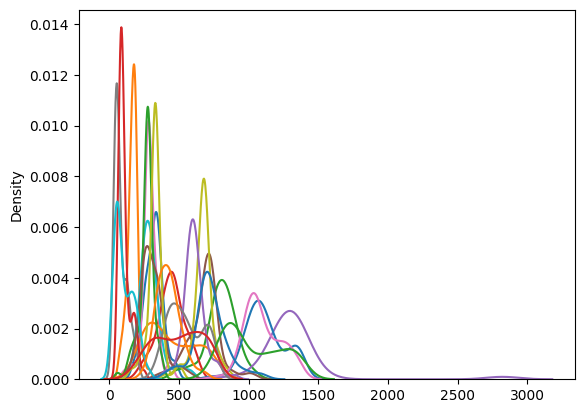

In [69]:
# run this code 

for i in range(data.shape[1]):
    sns.kdeplot(data[:,i])

**<span style="color:#873600">Question</span>**: What the previous plot tells us? Do we need to normalize our data? Answer in the next cell. Justify your answer.

No matter what your answer was in the previous question, use one technique to normalize the data. 

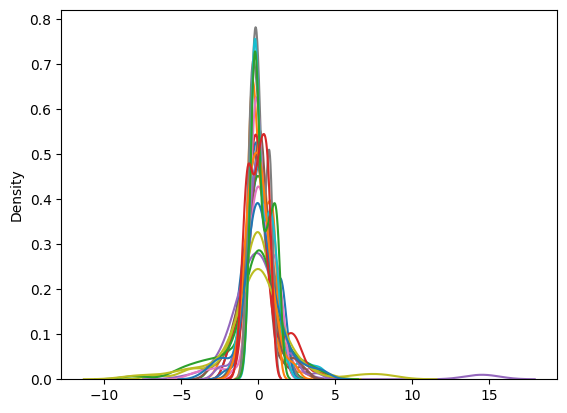

In [70]:
# run this code

scaler = RobustScaler()
data = scaler.fit_transform(data)
for i in range(data.shape[1]):
    sns.kdeplot(data[:,i])

**<span style="color:#873600">Question</span>**: Why did you choose this normalization technique? What is it doing? Answer in the next cell.

Answer: This normalization technique was already coded. It's simply taking the values of each feature and changing the values to fit a standard normal scale.

## <span style="color:#873600">Task 6: Examine the effect of feature engineering</span>

In this task you will run a machine learning classifier (SVM) on different combinations of features that you created in task 2.

Briefly explain your best model's features and why you think they worked well.

*Keep in mind that for 100% credit you want at least one configuration (of feature engineering -- task 2) that provides above 95% accuracy when run through the SVM code below. Otherwise there will be a penalty of 10 points.*

In [71]:
# run this code

xtrain, xtest, ytrain, ytest = train_test_split(data, labels, test_size=0.30, random_state=42)

#training the model
clf = SVC() #note the default kernel here is 'rbf' - radial basis function
clf.fit(xtrain, ytrain)
cv_scores = cross_val_score(clf, xtrain, ytrain, cv=10)
print('Average Cross Validation Score from Training:', cv_scores.mean(), sep='\n', end='\n\n\n')

#testing the model
ypred = clf.predict(xtest)
cm = confusion_matrix(ytest, ypred)
cr = classification_report(ytest, ypred)

print('Confusion Matrix:', cm, sep='\n', end='\n\n\n')
print('Test Statistics:', cr, sep='\n', end='\n\n\n')

#This is what we will be grading (>95 expected)
print('Testing Accuracy:', accuracy_score(ytest, ypred))


Average Cross Validation Score from Training:
0.9550000000000001


Confusion Matrix:
[[ 9  0]
 [ 0 12]]


Test Statistics:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         9
         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



Testing Accuracy: 1.0


Explain your model performance: 

For this model, I tried several combinations of features by commenting out specific features from task 2 and rerunning the notebook. Each combination gave varying levels of success, and I tried each out without a random state so I could perform multiple runs to see what worked best in the majority of cases. Overall, including all 6 features I came up with (standard deviation of x and y, mean of x and y, and the range of x and y) provided the best results consistently. I believe this to be the case due to SVM naturally being able to use the best features where it sees fit when using the rbf kernel, and the fact that each of the data points provides some meaningful data about each individual. I believe the standard deviation and the range of the xy coordinates were the most important features, as when viewing the video it appeared that the autistic individuals tended to be much less focused and more scattered than non-autistic individuals, which would show up in both range and standard deviation.

## <span style="color:#873600">Task 7: Modifying SVM</span>

SVM allows for different kernels as you learned in class. Modify the code from task 6 to implement two other SVM kernels.

Briefly explain the differences you see between different kernels.

In [72]:
# ADD CODE HERE #

# USING POLYNOMIAL KERNEL

#training the model
clf = SVC(kernel='poly') 
clf.fit(xtrain, ytrain)
cv_scores = cross_val_score(clf, xtrain, ytrain, cv=10)
print('Average Cross Validation Score from Training:', cv_scores.mean(), sep='\n', end='\n\n\n')

#testing the model
ypred = clf.predict(xtest)
cm = confusion_matrix(ytest, ypred)
cr = classification_report(ytest, ypred)

print('Confusion Matrix:', cm, sep='\n', end='\n\n\n')
print('Test Statistics:', cr, sep='\n', end='\n\n\n')

#This is what we will be grading (>95 expected)
print('Testing Accuracy:', accuracy_score(ytest, ypred))


Average Cross Validation Score from Training:
0.6900000000000001


Confusion Matrix:
[[ 9  0]
 [10  2]]


Test Statistics:
              precision    recall  f1-score   support

         0.0       0.47      1.00      0.64         9
         1.0       1.00      0.17      0.29        12

    accuracy                           0.52        21
   macro avg       0.74      0.58      0.46        21
weighted avg       0.77      0.52      0.44        21



Testing Accuracy: 0.5238095238095238


In [73]:
# ADD CODE HERE #

# USING SIGMOID KERNEL

#training the model
clf = SVC(kernel='sigmoid') 
clf.fit(xtrain, ytrain)
cv_scores = cross_val_score(clf, xtrain, ytrain, cv=10)
print('Average Cross Validation Score from Training:', cv_scores.mean(), sep='\n', end='\n\n\n')

#testing the model
ypred = clf.predict(xtest)
cm = confusion_matrix(ytest, ypred)
cr = classification_report(ytest, ypred)

print('Confusion Matrix:', cm, sep='\n', end='\n\n\n')
print('Test Statistics:', cr, sep='\n', end='\n\n\n')

#This is what we will be grading (>95 expected)
print('Testing Accuracy:', accuracy_score(ytest, ypred))


Average Cross Validation Score from Training:
0.9550000000000001


Confusion Matrix:
[[ 9  0]
 [ 0 12]]


Test Statistics:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         9
         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



Testing Accuracy: 1.0


Explanation: We can see that the polynomial kernel performs significantly worse than the rbf and sigmoid kernel, even though several degrees were tested. 
Sigmoid kernel, on the other hand, performs similarly to the rbf kernel. This would suggest that sigmoid or rbf could serve as the optimal kernel for this problem given the features used.

--------------------------------------------------------------------------------------------------------

## Looking at decision boundaries and spread of data
### This is for exploration and will not be graded

In [74]:
#Give index of features that you are interested in looking at
sub_features = [4,5]

scores = []
cv = KFold(n_splits=3, random_state=42, shuffle=True)
for train_index, test_index in cv.split(data):
    #print("Train Index: ", train_index)
    #print("Test Index: ", test_index)
    X_train, X_test, y_train, y_test = data[train_index], data[test_index], labels[train_index], labels[test_index]



Mean Accuracy :  0.8695652173913043
This accuracy number is not used for evaluating your solution as it only looks at a subset of features.


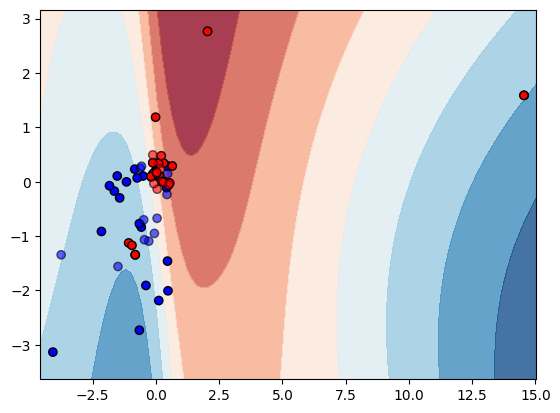

In [75]:
h = .2  # step size in the mesh
x_min, x_max = data[:, 2].min() - .5, data[:, 2].max() + .5
y_min, y_max = data[:, 3].min() - .5, data[:, 3].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
h = .2  # step size in the mesh
x_min, x_max = data[:, sub_features[0]].min() - .5, data[:, sub_features[0]].max() + .5
y_min, y_max = data[:, sub_features[1]].min() - .5, data[:, sub_features[1]].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

# Plot the training points
clf.fit(X_train[:,sub_features],y_train)
scores.append(clf.score(X_test[:,sub_features], y_test))
print('Mean Accuracy : ',str(np.mean(scores)))
print('This accuracy number is not used for evaluating your solution as it only looks at a subset of features.')
if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
fig = plt.figure()

Z = Z.reshape(xx.shape)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    
plt.scatter(X_train[:, sub_features[0]], X_train[:, sub_features[1]], c=y_train, cmap=cm_bright, edgecolors='k')
plt.scatter(X_test[:, sub_features[0]], X_test[:, sub_features[1]], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors='k')


plt.show()

## Grading Strategy:
<ul>
    <li>Task1      0% (written for you)</li>
    <li>Task2     20%</li>
    <li>Task3     20%</li>
    <li>Task4      0% (written for you) </li>
    <li>Task5     20%</li>
    <li>Task6     25% (explanation)</li>
    <li>Task7     15% (5% per kernel, 5% explanation)</li>

    There will be a -10 penalty if none of the classifiers you create (from tasks 6 and 7) 
    have an accuracy of ~95.

    You can get +5 extra credit by modifying task 1 to use additional files (please indicate that you 
    use additional files, there is a yes/no comment that you have to write in Task 1 to indicate that).

</ul>